# PS.4 (qr-decomposition)

For $A\in\mathbb{R}^{m\times n}$ with $rank(A)=n$, the solution of 

\begin{equation*}
\arg\min_{x\in\mathbb{R}^n} \|Ax - b\|_2.
\end{equation*}

via the qr-decomposition $A=Q R$ is given by

\begin{equation*}
R=
\begin{pmatrix}
R_0\\ 0
\end{pmatrix},
\qquad \begin{pmatrix}c_0\\c_1\end{pmatrix}=Q^\top b,\qquad R_0 x= c_0.
\end{equation*}

a) Write a function myLLS that takes $A$ as input and returns the solution of the lls problem by calling myQR. 

b) Check your implementation by running the testset.


In [1]:
using LinearAlgebra
function myQR(A)
    m, n = size(A)
    Q = Matrix{Float64}(I,m,m)
    if eltype(A) == ComplexF64 Q = Matrix{ComplexF64}(I,m,m) end
    R = copy(A)
    for k = 1:n
        a = R[k:m,k]
        v = copy(a)
        v[1] += sign(a[1])*norm(a)
        v = v/norm(v)
        Q[k:m,1:m] .= Q[k:m,1:m].-2*v*v'*Q[k:m,1:m]   
        R[k:m,k:n] .= R[k:m,k:n].-2*v*v'*R[k:m,k:n]   
    end
    return Q[1:m,1:m]', triu(R[1:m,1:n])
end

myQR (generic function with 1 method)

In [2]:
function myLLS(A::Matrix,b)
    Q,R = myQR(A)
    n = size(A,2)
    R0 = R[1:n,:]
    c0 = Q'[1:n,:]*b
    return R0\c0
end

myLLS (generic function with 1 method)

In [3]:
using Test
@testset "myQR" begin   
    m = 200
    n = 100
    ϵ = 1e-13
    for k in 1:10
        A = randn(m,n)+randn(m,n)*1im   # maybe you need to remove the irrational part
        b = randn(m)+randn(m)*1im       # maybe you need to remove the irrational part
        
        Q,R = myQR(A)
        
        @test istriu(R)
        @test norm(Q*Q'-I) < ϵ
        @test norm(Q*R-A)/norm(A) < ϵ

        x = myLLS(A,b)

        @test norm(A'*A*x-A'*b)/norm(A) < ϵ
    end
end

Test Summary: | Pass  Total  Time
myQR          |   40     40  1.8s


Test.DefaultTestSet("myQR", Any[], 40, false, false, true, 1.668165628716667e9, 1.668165630507067e9)

# PS.4 (qr-algorithm for eigenvalues)

Given $A_1:=A$, compute

\begin{align*}
Q_k R_k & = A_k & \text{qr-decomposition of $A_k$}\\
A_{k+1} & = R_k Q_k & \text{recombine factors in reverse order}
\end{align*}

For $k\rightarrow\infty$ and $A$ symmetric and regular, we have

\begin{equation*}
A_k\rightarrow 
\begin{pmatrix}
\lambda_1\\
& \ddots \\
&&\lambda_n
\end{pmatrix},
\qquad Q_1Q_2\cdots Q_k \rightarrow V=(v_1,\ldots,v_n),\qquad A v_j = \lambda_j v_j.
\end{equation*}

a) Write a julia function that computes eigenvalues and eigenvectors via the qr-algorithm.

In [4]:
# using LinearAlgebra
function myEigs(A0;tol = 1e-5,maxiter = 1000)  # A0 symmetric
    A = copy(A0)
    local Q
    local R
    V = I
    for k in 1:maxiter
        Q,R = qr(A)
        V = V * Q
        if norm(A-Diagonal(A))<tol return diag(A),V end
        A = R * Q
    end
    println("iteration limit exceeded")
    return diag(Q*R),V    # maybe order them ?
end

myEigs (generic function with 1 method)

We have

\begin{equation*}
A v_j = \lambda_j v_j,\quad j=1,\ldots,n \quad\Leftrightarrow\quad AV=\left(A v_1,\ldots,A v_n\right) = \left(\lambda_1 v_1,\ldots,\lambda_n v_n\right)=V\begin{pmatrix}\lambda_1\\&\ddots\\ &&\lambda_n\end{pmatrix}
\end{equation*}

b) Check your implementation with the following testset and then determine the eigenvalues and eigenvectors of the matrices $A$ and $B$ given below. Can you determine the exact values?

In [5]:
using Test
@testset "myEigs" begin     
    for n in 2:10
        A = rand(n,n)
        A .= A'+A
        
        λ,V = myEigs(A; tol = 1e-8, maxiter = 10000)
            
        @test norm(A*V-V*diagm(λ)) < cond(A)*1e-5
    
    end
end

Test Summary: | Pass  Total  Time
myEigs        |    9      9  0.4s


Test.DefaultTestSet("myEigs", Any[], 9, false, false, true, 1.668165631462329e9, 1.668165631830665e9)

In [6]:
A = [-4  0 -4 -3  4;0  3 -4  0 -4;-4 -4 -4 -4  3;-3  0 -4 -4  4;4 -4  3  4 -4]
B = [ 2 -3  4  0  0; -3  2  4  0  0; 4  4  3  0  0; 0  0  0 -4  4; 0  0  0  4  2]

5×5 Matrix{Int64}:
  2  -3  4   0  0
 -3   2  4   0  0
  4   4  3   0  0
  0   0  0  -4  4
  0   0  0   4  2

In [7]:
λ,V = myEigs(A;tol = 1e-8, maxiter = 600000)
@show λ;

λ = [-15.0, 6.999999999999991, -4.999999999999994, -1.0000000000000013, 0.999999999999999]


In [8]:
V

5×5 Matrix{Float64}:
  0.5           1.805e-18    7.32692e-17  -0.707107      0.5
  1.46358e-17   0.816497     0.57735       1.76785e-16  -1.20569e-17
  0.5          -0.408248     0.57735       2.47045e-16  -0.5
  0.5           8.75086e-17  3.16951e-17   0.707107      0.5
 -0.5          -0.408248     0.57735       1.01173e-16   0.5

In [9]:
v1 = [1;0;1;1;-1]
v2 = [0;2;-1;0;-1]
v3 = [0;1;1;0;1]
v4 = [-1;0;0;1;0]
v5 = [1;0;-1;1;1]

A*v1 == -15*v1,   # integer arithmetic
A*v2 == 7*v2,
A*v3 == -5*v3,
A*v4 == -v4,
A*v5 == v5

(true, true, true, true, true)

# PS.4 (Gershgorin circles)

Consider $A = (a_{ij}) \in \mathbb{C}^{n \times n}$ and
\begin{align}
C:= \bigcup_{i=1}^n C_i,
\qquad
C_i = \Big\{ \xi \in \mathbb{C}: |\xi - a_{ii}| \leq \sum_{\substack{j=1 \\ j \neq i}}^n |a_{ij}| \Big\}.
\end{align}

a) Prove that if $\lambda$ is an eigenvalue of $A$, then $\lambda\in C$.

b) Illustrate Part a) for a few matrices of your choice by plotting the circles and the eigenvalues appropriately.

## Solution 
For $A x = \lambda x$ with $x \neq 0$, we choose $i$ with $|x_i| \geq |x_j|$ for all $j \neq i$. Then we obtain

$$
\lambda x_i = (A x)_i = \sum_{j=1}^n a_{ij} x_j.
$$
Therefore, 
$$
|\lambda - a_{ii}|= \bigg|
\sum_{j \neq i} a_{ij} \frac{x_j}{x_i}
\bigg|
\leq
\sum_{j \neq i} |a_{ij}|.
$$

In [1]:
using Plots, LinearAlgebra

function circle(x, y = 0, r = 1; n=100)
    θ = 0:1/n:2π
    Plots.Shape(r*sin.(θ) .+ x, r*cos.(θ) .+ y)
end

function myGershgorin(A)
    n = size(A,1)
    d = diag(A)
    r = sum(abs.(A),dims=2).-abs.(d)
    p = plot(circle(real(d[1]),imag(d[1]),r[1]);fillalpha=0.5,aspect_ratio=1,label="C1")
    for k in 2:n
        plot!(circle(real(d[k]),imag(d[k]),r[k]),fillalpha=0.5,label="C$k")
    end
    λ = eigen(A).values
    scatter!(real.(λ),imag.(λ),label="λ")
    display(p)
end

myGershgorin (generic function with 1 method)

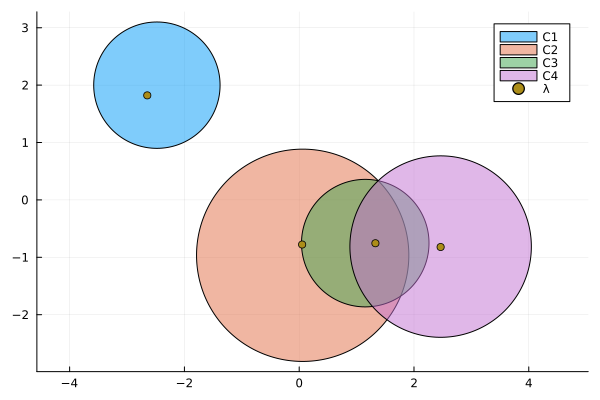

In [7]:
A = Diagonal(randn(4)+1im*randn(4))+randn(4,4)/2
myGershgorin(A)

# PS.4 (Convergence order)

For fixed $r,s>1$, consider the sequence 
\begin{equation*}
x_k = s^{-r^k}, \qquad k=0,1,2,\ldots
\end{equation*}

a) What is the convergence order of $(x_k)_{k\in\mathbb{N}}$ ?

b) What is the convergence order of $y_k = s^{-k}$, $k=0,1,2,\ldots$ ? Plot $(y_k)_{k\in\mathbb{N}}$, for $s=3,4,5$, in a logarithmic scale.

## Solution

a) The limit is $x=0$ and we observe

\begin{align*}
\frac{|x_{k+1}-x|}{|x_{k}-x|^r} = \frac{s^{-r^{k+1}}}{(s^{-r^{k}})^r} = \frac{s^{-r^{k}r}}{s^{-r^{k}r}} = 1.
\end{align*}

Therefore, the convergence order is $r$.

b) The limit is $y=0$ and we observe

\begin{align*}
\frac{|y_{k+1}-y|}{|y_{k}-y|} = \frac{s^{-(k+1)}}{s^{-k}} = \frac{s^{-1}s^{-k}}{s^{-k}} = \frac{1}{s}<1.
\end{align*}

Therefore, $y_k\rightarrow 0$ with linear convergence.

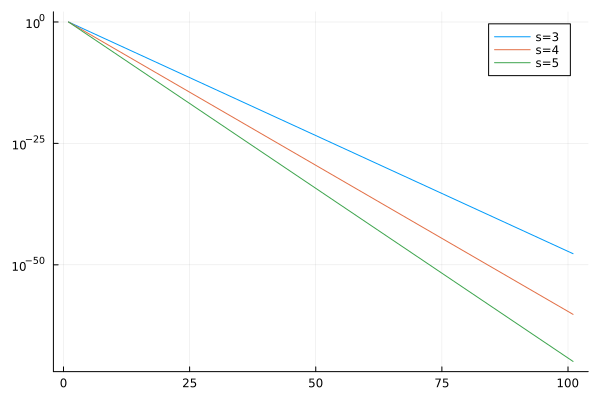

In [13]:
using Plots
n = 100
k = 0:n
s = float.([3,4,5])
plot(s[1].^(-k),yaxis=:log, label="s=3")
plot!(s[2].^(-k),yaxis=:log, label="s=4")
plot!(s[3].^(-k),yaxis=:log, label="s=5")